**Importing Needed Libraries**

In [ ]:
#Arno and Sevlay are using this copy so we don't break your working version as we play with your code
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from datetime import datetime

In [ ]:
%load_ext tensorboard

In [ ]:
# Mount google drive so that we can access data
# from google.colab import drive
# drive.mount('/content/drive')
!ls "/content/drive"

ls: cannot access '/content/drive': No such file or directory


In [ ]:
# Path where Syed wants to keep cifar10 data on his google drive to keep things organized
google_drive_path = './drive/MyDrive/Colab Notebooks/3337_Project'

In [ ]:
# Defining global variables and hyperparameters
LEARNING_RATE = 0.03 # 0.001
BATCH_SIZE = 16
NUM_EPOCHS = 30
cifar10_classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Transformations applied to images as they are loaded by the Pytorch dataloader
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)


In [ ]:
# Create dataset and dataloader for cifar10. Pytorch built-in dataloaders handle downloading
# the cifar10 dataset to a location mounted on Syed's google drive.
# Separate dataloaders for training and test set of cifar10
# - root: path to directory within google drive where cifar10 will be downloaded
# - train: whether or not dataloader is for training
# - download: whether or not to download the cifar10 zip file (to store image data locally)
# - transform: pass previously defined transformations into dataloader, will be applied to images

trainset = torchvision.datasets.CIFAR10(root=google_drive_path, train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root=google_drive_path, train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./drive/MyDrive/Colab Notebooks/3337_Project/cifar-10-python.tar.gz to ./drive/MyDrive/Colab Notebooks/3337_Project
Files already downloaded and verified


In [ ]:
# Function to show images
def show_img(img):
    img = img / 2 + 0.5     # unnormalize
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

Images: torch.Size([16, 3, 32, 32])
Labels: torch.Size([16])
tensor([7, 3, 6, 7, 5, 6, 1, 6, 3, 0, 3, 0, 3, 7, 0, 4])


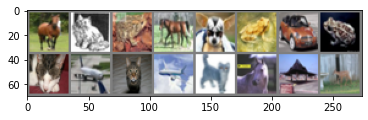

horse   cat  frog horse   dog  frog   car  frog   cat plane   cat plane   cat horse plane  deer


In [ ]:
# Get a few cifar10 images for visualizing
dataiter = iter(trainloader)  # Makes an iterable object in Python for training dataloader
images, labels = dataiter.next()  # Get one batch of images (16 images)

print("Images:", images.shape)
print("Labels:", labels.shape)
print(labels)

# Show images
show_img(torchvision.utils.make_grid(images))
# Print labels
print(' '.join('%5s' % cifar10_classes[labels[j]] for j in range(BATCH_SIZE)))

In [ ]:
images.shape  # batch of 8 images, each image has 3 channels, 32x32 image

torch.Size([16, 3, 32, 32])

In [ ]:
images[0].shape

torch.Size([3, 32, 32])

**Defining Convolutional Neural Network**

In [ ]:
# class Simple_CNN(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(3, 6, 5)  # [3,32,32]  -> [6,30,30]
#         self.pool = nn.MaxPool2d(2, 2)  # [6,30,30] -> [6,15,15]
#         self.conv2 = nn.Conv2d(6, 16, 5)
#         self.fc1 = nn.Linear(16 * 5 * 5, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 10)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = torch.flatten(x, 1) # flatten all dimensions except batch
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

In [ ]:
# net = Simple_CNN()
resnet18 = torchvision.models.resnet18(num_classes=10)

In [ ]:
criterion = nn.CrossEntropyLoss()  # Loss function
optimizer = optim.SGD(resnet18.parameters(), lr=LEARNING_RATE, momentum=0.9)  # Optimizer object that tweaks weights in neural network

**Training Loop for Neural Network**

In [ ]:
experiment_name = "resnet18_30ep"
date_time_str = datetime.now().strftime('%Y%m%d_%H%M%S')
experiment_log_name = '{}_{}'.format(experiment_name, date_time_str)

In [ ]:
writer_train = SummaryWriter('logs/{}/train'.format(experiment_log_name))
writer_val = SummaryWriter('logs/{}/validation'.format(experiment_log_name))
print('logs/{}/train'.format(experiment_log_name))
print('logs/{}/validation'.format(experiment_log_name))

logs/resnet18_30ep_20211026_164220/train
logs/resnet18_30ep_20211026_164220/validation


In [ ]:
%tensorboard --logdir logs/resnet18_30ep_20211026_164220

In [ ]:
def eval(resnet18, epoch):
  resnet18.eval()
  running_loss = 0.0
  num_correct = 0
  for i, data in enumerate(testloader, 0):
    inputs, labels = data
    optimizer.zero_grad()

    outputs = resnet18(inputs)
    loss = criterion(outputs, labels)
    
    running_loss += loss.item() * images.size(0)
    num_correct += (torch.argmax(outputs, dim=1) == labels).float().sum()
  
  epoch_accuracy = 100 * (num_correct / len(testset))
  epoch_loss_average = running_loss / len(testset)
  writer_val.add_scalar('loss', epoch_loss_average, epoch)
  writer_val.add_scalar('acc', epoch_accuracy, epoch)

In [ ]:
loss_values = []
for epoch in range(NUM_EPOCHS):  # loop over the dataset multiple times
    print("Epoch", epoch)
    running_loss = 0.0
    num_correct = 0
    resnet18.train()
    for i, data in enumerate(trainloader, 0):
        # Get inputs; Data is a list of [inputs, labels]
        inputs, labels = data

        # Zero Parameter Gradients From Previous Computations
        optimizer.zero_grad()

        # Pass images through Neural Network, compute loss and gradients, propagate backwards
        outputs = resnet18(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        num_correct += (torch.argmax(outputs, dim=1) == labels).float().sum()

    epoch_accuracy = 100 * (num_correct / len(trainset))
    epoch_loss_average = running_loss / len(trainset)
    writer_train.add_scalar('loss', epoch_loss_average, epoch)
    writer_train.add_scalar('acc', epoch_accuracy, epoch)

    # Evaluate CNN on validation set once per epoch
    eval(resnet18, epoch)

print('Finished Training')

Epoch 0


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1
Epoch 2
Epoch 3


KeyboardInterrupt: ignored

**Evaluate Neural Network on Test Set**